# Age Estimation and Gender Classification

In this assignment, you will train CNN models to estimate a person's age and gender by given a face image. Please read carefully all the instructions before you start to write your code.

**Your tasks**

You need train two CNN models:
- one is defined by you with a few restrictions and be trained from scratch, save it as `age_gender_A.h5`
- the other is to finetune a pretrained model, save it as `age_gender_B.h5`

**Dataset**

Your models will be trained and validated on a folder `train_val/` containing 5,000 labeled face images (size: 128 x 128), originated from the UTKFace dataset. During marking, your code will be tested on unseen test data. 

**Performance metric**

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy

**Please use the GPU time wisely.**

Just be aware that there is some limit of free GPU usage (It is said the users can use up to 12 hours in row. But many people found they reached its limit far less than 12 hours.). Therefore, I would give you three suggestions to mimimise the risk of reaching the limit.

1. Make sure you have a stable internet connection.
2. Double check all the hyperparameters are good before you start to train the model.
3. According to my experience, each model should be trained in less than 2 hours. If much longer than that, you'd better consider adjusting the architecture.

## Setting Up: Mount the google drive
Mount your google drive to the notebook. 

Also don't forget to **enable GPU** before your training.


In [1]:
#
# Add your code here
#
# ARNAU: Only run this in Google Colab
# from google.colab import drive
# drive.mount('/content/drive')


## Visualize a few photos
It is always benificial to know your data well before you start. Here display a few (at least 20) images together with its corresponding age and gender from the `train_val/` folder to have a first impression of the dataset. You may also check what the size of the images are.

Image 1 size: (128, 128)
Image 2 size: (128, 128)
Image 3 size: (128, 128)
Image 4 size: (128, 128)
Image 5 size: (128, 128)
Image 6 size: (128, 128)
Image 7 size: (128, 128)
Image 8 size: (128, 128)
Image 9 size: (128, 128)
Image 10 size: (128, 128)
Image 11 size: (128, 128)
Image 12 size: (128, 128)
Image 13 size: (128, 128)
Image 14 size: (128, 128)
Image 15 size: (128, 128)
Image 16 size: (128, 128)
Image 17 size: (128, 128)
Image 18 size: (128, 128)
Image 19 size: (128, 128)
Image 20 size: (128, 128)


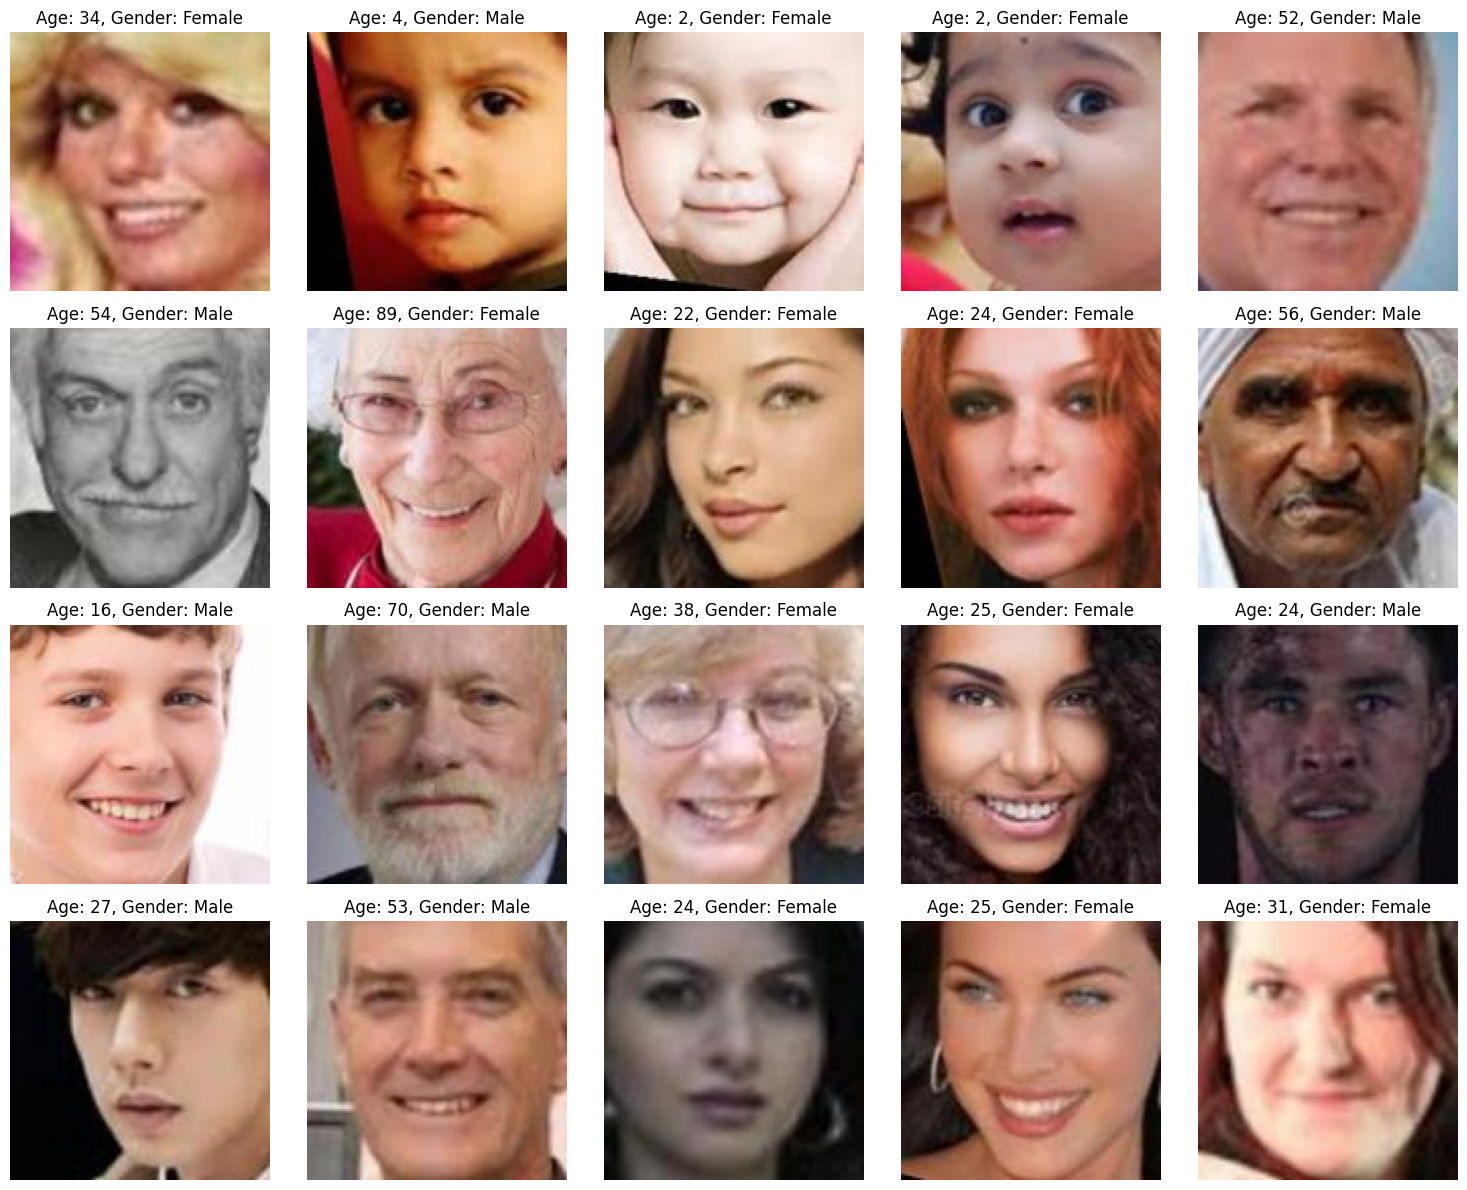

In [1]:
#
# Add your code here
#
# ARNAU: Download data and put in root level with folder name 'train_val'
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Set the path to the train_val folder
train_val_path = './train_val'

# Get a list of all image files in the train_val folder
image_files = [f for f in os.listdir(train_val_path) if f.endswith('.jpg')]

# Randomly select 20 images
selected_images = random.sample(image_files, 20)

# Create a figure with subplots
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.flatten()

# Iterate over the selected images and display them with labels
for i, image_file in enumerate(selected_images):
    # Extract age and gender from the file name
    age, gender = image_file.split('_')[:2]
    age = int(age)
    gender = 'Male' if gender == '0' else 'Female'
    
    # Load the image
    image_path = os.path.join(train_val_path, image_file)
    image = Image.open(image_path)
    
    # Display the image and labels
    axes[i].imshow(image)
    axes[i].set_title(f'Age: {age}, Gender: {gender}')
    axes[i].axis('off')
    
    # Print the image size
    print(f'Image {i+1} size: {image.size}')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


## Rearrange the dataset
You may do any arrangement for the dataset to suit your later process, such as splitting into training set and validation set, saving the gender labels and age some how, and so on.


### Visualing
- Below I added a few cells to visualise a bit the dataset but this was more to get to know the data than anything else

## STEP1: Data pre-processing
Now you need do some pre-processing before feeding data into a CNN network. You may consider:

1.	Rescale the pixel values (integers between 0 and 255) to [0,1]. **You must do this rescaling.** Otherwise the testing performance will be affected significantly, as the test images will be rescaling in this way. 
2.	Data augmentation.

**Don't rescale the age to [0,1].** Otherwise the testing performance will be affected significantly, as the original age is used in the testing stage. 

In [2]:
import numpy as np
import os
import glob
from sklearn.model_selection import train_test_split
from PIL import Image
import pandas as pd

# Assuming the necessary variables like dataset_folder_name are already defined
dataset_folder_name = 'train_val'
IM_WIDTH = IM_HEIGHT = 128

# Define your dataset dictionary for gender
dataset_dict = {
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}
dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())

def parse_dataset(dataset_path, ext='jpg'):
    """
    Used to extract information about our dataset. It iterates over all images and returns a DataFrame with
    the data (age, gender, and file path) of all files.
    """
    def parse_info_from_file(path):
        """
        Parse information from a single file
        """
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender = filename.split('_')[:2]  # Only extract age and gender, ignore other info
            return int(age), dataset_dict['gender_id'][int(gender)], path
        except Exception as ex:
            return None, None, None
        
    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    
    records = []
    for file in files:
        age, gender, file_path = parse_info_from_file(file)
        if age is not None and gender is not None:
            records.append((age, gender, file_path))
        
    df = pd.DataFrame(records, columns=['age', 'gender', 'file'])
    return df

# Parse the dataset
df = parse_dataset(dataset_folder_name)

# Convert gender to numeric id
df['gender_id'] = df['gender'].map(lambda gender: dataset_dict['gender_alias'][gender])

# Split the dataset into training, validation, and test sets (70/15/15)
X_train_val, X_test, y_train_val_age, y_test_age, y_train_val_gender, y_test_gender = train_test_split(
    df['file'], df['age'], df['gender_id'], test_size=0.15, random_state=42)

X_train, X_val, y_train_age, y_val_age, y_train_gender, y_val_gender = train_test_split(
    X_train_val, y_train_val_age, y_train_val_gender, test_size=0.1765, random_state=42)  # 0.1765 ≈ 1 - 0.8235 to achieve 70/15/15 split

# Print the number of entries in each set to verify the split
print(f"Number of training entries: {len(X_train)}")
print(f"Number of validation entries: {len(X_val)}")
print(f"Number of test entries: {len(X_test)}")

# Optionally, save the split data for later use
np.savez('train_val_test_split_701515.npz', X_train=list(X_train), X_val=list(X_val), X_test=list(X_test),
         y_train_age=list(y_train_age), y_val_age=list(y_val_age), y_test_age=list(y_test_age),
         y_train_gender=list(y_train_gender), y_val_gender=list(y_val_gender), y_test_gender=list(y_test_gender))

Number of training entries: 3499
Number of validation entries: 751
Number of test entries: 750


In [3]:
# Create DataFrames for training, validation, and test sets
df_train = pd.DataFrame({'file': X_train, 'age': y_train_age, 'gender_id': y_train_gender})
df_val = pd.DataFrame({'file': X_val, 'age': y_val_age, 'gender_id': y_val_gender})
df_test = pd.DataFrame({'file': X_test, 'age': y_test_age, 'gender_id': y_test_gender})


In [4]:
df_train.head()

,file,age,gender_id
3931,train_val/35_0_2_20170116191223232.jpg.chip.jpg,35,0
520,train_val/39_0_1_20170116193433706.jpg.chip.jpg,39,0
4688,train_val/18_0_0_20170110231524976.jpg.chip.jpg,18,0
2563,train_val/15_1_1_20170104005130400.jpg.chip.jpg,15,1
161,train_val/75_0_0_20170117174423110.jpg.chip.jpg,75,0


In [10]:
df_val.tail()

,file,age,gender_id
1621,train_val/28_0_0_20170117202358254.jpg.chip.jpg,28,0
1598,train_val/38_1_4_20170116233353646.jpg.chip.jpg,38,1
1390,train_val/35_1_3_20170104235558235.jpg.chip.jpg,35,1
2455,train_val/85_1_0_20170110183802977.jpg.chip.jpg,85,1
3539,train_val/49_1_0_20170109221050190.jpg.chip.jpg,49,1


In [8]:
import numpy as np
import os
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from PIL import Image

# Assuming df is your DataFrame containing the dataset with 'file', 'age', and 'gender' columns
# and you have already split df into training, validation, and test DataFrames: df_train, df_val, df_test

class MultiOutputDataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, dataframe, directory, batch_size=32, image_size=(128, 128), shuffle=True, augment=False):
        'Initialization'
        self.dataframe = dataframe.reset_index(drop=True)
        self.directory = directory
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()
        
        if augment:
            self.datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest'
            )
        else:
            self.datagen = ImageDataGenerator(rescale=1./255)
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.dataframe) / self.batch_size))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        # Find list of IDs
        batch_ids = [self.dataframe.iloc[k] for k in indexes]
        
        # Generate data
        X, y = self.__data_generation(batch_ids)
        
        return X, y
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.dataframe))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __data_generation(self, batch_ids):
        'Generates data containing batch_size samples' 
        X = np.empty((self.batch_size, *self.image_size, 3))
        y_age = np.empty((self.batch_size, 1), dtype=int)
        y_gender = np.empty((self.batch_size, 1), dtype=int)
        
        # Generate data
        for i, ID in enumerate(batch_ids):
            # Store sample
            img_path = os.path.join(self.directory, ID['file'])
            img = Image.open(img_path)
            img = img.resize(self.image_size)
            img_array = np.array(img) / 255.0
            
            X[i,] = self.datagen.random_transform(img_array) if self.augment else img_array
            
            # Store class
            y_age[i] = ID['age']
            y_gender[i] = ID['gender_id']
        
        return X, {'age_output': y_age, 'gender_output': y_gender}

# Example usage:
# Assuming df_train, df_val, and df_test are your training, validation, and test DataFrames respectively
train_generator = MultiOutputDataGenerator(df_train, '', batch_size=32, augment=True)
validation_generator = MultiOutputDataGenerator(df_val, '', batch_size=32, augment=False)

# Fetch a batch for verification
X, y = next(iter(train_generator))
print(f"Batch X shape: {X.shape}")
print(f"Batch y age shape: {y['age_output'].shape}")
print(f"Batch y gender shape: {y['gender_output'].shape}")

Batch X shape: (32, 128, 128, 3)
Batch y age shape: (32, 1)
Batch y gender shape: (32, 1)


## STEP2A: Build your own CNN network
Define your own CNN for classifying the gender and predicting the age. Though there are two tasks, you need **only one CNN model, but with two outputs** - you may search online for solution.

There are a few restrictions about your network as follows.
1.	The input size must be 128 x 128 x 3, which means you **should not resize** the original images. This is because my test code relies on this particular input size. Any other size will cause problem in the testing stage.
2.  Please treat the gender classification as a binary problem, i.e., **the output layer for the gender branch has only 1 unit**, instead of 2 (though it is correct to treat the gender classification as a mutli-class problem where class number is 2, the last layer has 2 units). This is because my test code only works for the 1-unit-last-layer gender branch setting. 
3.	The size of feature maps being fed to the first fully connected layer must be less than 10 x 10, while there is no number limitation about the depth.
4.	You may choose any techniques for preventing overfitting. 

In the end of the cell, use `modelA.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.

In [8]:
#
# Add your code here
#


modelA.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelA, show_shapes=True)

NameError: name 'modelA' is not defined

## STEP3A: Compile and train your model
Compile and train your model here. 
Save your model by `modelA.save(your_model_folder+"age_gender_A.h5")` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Save the model with `save()` instead of `save_weights()`.** This is because I will load the model by 

`modelA = load_model(model_folder+"age_gender_A.h5")`. 


In [ ]:
#
# Add your code here
#

modelA.save(your_model_folder+"age_gender_A.h5")

## STEP4A: Draw the learning curves
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set


In [ ]:
#
# Add your code here
#


## STEP2B: Build a CNN network based on a pre-trained model 
Choose one existing CNN architecture pre-trained on ImageNet, and fine-tune on this dataset.

The same as required in Model A, **don’t resize the input image size**. **The output layer for the gender branch is set to have only 1 unit**. 

In the end of the cell, use `modelB.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.


/var/folders/db/09czvxz96tdcvm__y5ys0mzm0000gn/T/ipykernel_81978/1675827256.py:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(128, 128, 3)))


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 3,571,778 (13.63 MB)

 Trainable params: 1,313,794 (5.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

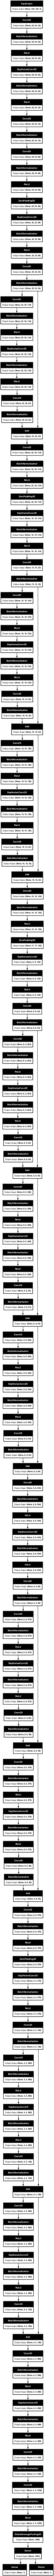

In [15]:
#
# Add your code here
#
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

# Load MobileNetV2 as the base model, excluding the top layer since we'll be adding our own
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(128, 128, 3)))

# Freeze the layers of the base model to prevent them from being updated during the first training phase
for layer in base_model.layers:
    layer.trainable = False

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)

# Add output layers
# For age prediction (regression)
age_output = Dense(1, name='age_output')(x)
# For gender prediction (binary classification)
gender_output = Dense(1, activation='sigmoid', name='gender_output')(x)

# Define the model with the input from the base model and the two outputs
modelB = Model(inputs=base_model.input, outputs=[age_output, gender_output])

# Compile the model
modelB.compile(optimizer='adam', 
               loss={'age_output': 'mse', 'gender_output': 'binary_crossentropy'},
               metrics={'age_output': ['mae'], 'gender_output': ['accuracy']},
               loss_weights={'age_output': 1.0, 'gender_output': 1.0})


# Optional: Visualize the model architecture
from tensorflow.keras.utils import plot_model
plot_model(modelB, to_file='modelB_architecture.png', show_shapes=True, dpi=50)
# Model summary
modelB.summary()

# Optional: Visualize the model architecture
from tensorflow.keras.utils import plot_model
plot_model(modelB, to_file='modelB_architecture.png', show_shapes=True, dpi=50)

## STEP3B: Compile and train your model
Compile and train your model here. 
Save your model to `age_gender_B.h5` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Also, save the model with `save()` instead of `save_weights()`.** 


In [16]:
#
# Add your code here
#


# Define callbacks
# ModelCheckpoint to save the model after every epoch

# EarlyStopping to stop training when the validation loss has not improved after 5 epochs

# Assuming you have already defined and compiled your model as `modelB`
# and you have your `train_generator` and `validation_generator` ready

# Train the model
history = modelB.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,  # Adjust the number of epochs based on when you see the validation loss plateauing
    verbose=1,
)

# After training, the best model is already saved to 'age_gender_B.h5' by the ModelCheckpoint callback
# If you need to manually save the model, you can use the following line:
modelB.save('age_gender_B.h5')

Epoch 1/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - age_output_mae: 13.8598 - gender_output_accuracy: 0.6266 - loss: 340.6288 - val_age_output_mae: 11.4160 - val_gender_output_accuracy: 0.7799 - val_loss: 223.9371
Epoch 2/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - age_output_mae: 10.1194 - gender_output_accuracy: 0.7011 - loss: 180.3286 - val_age_output_mae: 10.2378 - val_gender_output_accuracy: 0.7812 - val_loss: 187.5149
Epoch 3/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - age_output_mae: 9.8876 - gender_output_accuracy: 0.7226 - loss: 173.3534 - val_age_output_mae: 9.6434 - val_gender_output_accuracy: 0.7976 - val_loss: 171.2769
Epoch 4/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - age_output_mae: 9.5654 - gender_output_accuracy: 0.7406 - loss: 164.1557 - val_age_output_mae: 10.0229 - val_gender_output_accuracy: 0.7826 - val_loss: 184.7280
Epoch 5/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - age_output_mae: 9.3754 - gender_output_accuracy: 0.7455 - loss: 157.2776 - val_age_o

## STEP4B: Draw the learning curve
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set

In [17]:
history.history.keys()

dict_keys(['age_output_mae', 'gender_output_accuracy', 'loss', 'val_age_output_mae', 'val_gender_output_accuracy', 'val_loss'])

In [11]:
#
# Add your code here
#


## STEP5: Evaluate the model on the test set
I will add my test code here to test the two models you trained. The test set will not be available before your submission. 

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy


In [12]:
#
# Don't add code in this cell when submitting this file
#